In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/sample_submission.csv
/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/train.csv
/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/test.csv


# Preprocessing

In [2]:
import pandas as pd
data = pd.read_csv('/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/train.csv')
data.head()
print("Done")

Done


In [3]:
drop_cols = ['TargetID', 'DRUGID',
       'PUBCHCID', 'UNIPROID',
       'TARGNAME', 'SYNONYMS', 'FUNCTION', 'BIOCLASS',
       'Accession Number'] # 'ID' - less acc/f1

data.drop(drop_cols, inplace=True, axis=1)
data.head(5)
print("Done")

Done


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.drop('Target_Status', axis=1),
                                                  data['Target_Status'], random_state=42,
                                                  stratify=data['Target_Status'], shuffle=True)
print("Done")

Done


In [5]:
le_cols = ['DRUGTYPE', 'Drug_high_status', 'DRUGNAME',
       'Disease_of_highest_status', 'Drug_Status', 'GENENAME', 'SEQUENCE',
       'Disease']

In [6]:
from sklearn.preprocessing import LabelEncoder
for i in le_cols:
    le = LabelEncoder()
    X_train[i] = le.fit_transform(X_train[i])
    X_val[i] = X_val[i].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1 if pd.notna(x) else -1)
# X_test[col] = X_test[col].apply(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1 if pd.notna(x) else -1)
print("Done")

Done


In [7]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# y_val = le.transform(y_val)
y_val = y_val.apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1 if pd.notna(x) else -1)
print(le.classes_)
print("Done")

['Application submitted' 'Approved' 'Approved (orphan drug)'
 'BLA submitted' 'Clinical trial' 'Discontinued in Phase 1'
 'Discontinued in Phase 1/2' 'Discontinued in Phase 2'
 'Discontinued in Phase 2/3' 'Discontinued in Phase 2b'
 'Discontinued in Phase 3' 'Discontinued in Phase 4'
 'Discontinued in Preregistration' 'IND submitted' 'Investigative'
 'Patented' 'Phase 0' 'Phase 1' 'Phase 1/2' 'Phase 1/2a' 'Phase 1b'
 'Phase 1b/2a' 'Phase 2' 'Phase 2/3' 'Phase 2a' 'Phase 2b' 'Phase 3'
 'Phase 4' 'Preclinical' 'Preregistration' 'Registered' 'Terminated'
 'Withdrawn from market']
Done


In [8]:
X_train.head()

,ID,DRUGTYPE,Drug_high_status,DRUGNAME,Disease_of_highest_status,Drug_Status,GENENAME,SEQUENCE,Disease
88082,131977,4,0,808,487,1,549,593,271
36973,189122,4,0,2069,434,17,250,452,260
76161,112276,4,0,1071,607,12,1,157,515
5088,78657,4,0,2322,590,1,249,669,155
76923,39756,4,0,375,573,1,200,109,384


In [9]:
y_train[:5]

array([ 1,  1, 17,  7, 14])

# Trying all baselines - XGB works the best followed by CatBoost

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier(verbosity=0),
    "CatBoost": CatBoostClassifier(silent=True),
#     "Support Vector Classifier": SVC(),
#     "Decision Tree": DecisionTreeClassifier(),
#     "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
#     "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),  
}

# Initialize an empty list to store results
results_list = []

In [13]:
# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    
    # Append results to the list
    results_list.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1})
    print('-'*25)
    print(model_name)
    print('-'*25)
    print('Accuracy : ', accuracy)
    print('F1 Score : ', f1)
    print('*'*50)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-------------------------
Logistic Regression
-------------------------
Accuracy :  0.23680923205044316
F1 Score :  0.15387254746280993
**************************************************
-------------------------
Random Forest
-------------------------
Accuracy :  0.8648206531437749
F1 Score :  0.8641705222436125
**************************************************
-------------------------
XGBoost
-------------------------
Accuracy :  0.9460769734102671
F1 Score :  0.9460924605933527
**************************************************
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [15]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Print the results DataFrame
print(results_df)

                  Model  Accuracy  F1 Score
0   Logistic Regression  0.236809  0.153873
1         Random Forest  0.864821  0.864171
2               XGBoost  0.946077  0.946092
3              LightGBM  0.262388  0.267507
4              CatBoost  0.907739  0.907792
5  Gaussian Naive Bayes  0.244483  0.158927
6              AdaBoost  0.232824  0.131941


----

# Optuna for XGB

In [16]:
# import optuna
# import xgboost as xgb
# from sklearn.metrics import accuracy_score

# # Define the objective function
# def objective(trial):
#     # Suggest hyperparameters
#     param = {
#         'objective': 'multi:softmax',  # Use 'multi:softmax' for multi-class classification
#         'eval_metric': 'mlogloss',      # Multiclass log loss
#         'num_class': 33,                  # Set this to the number of classes in your target
#         'max_depth': trial.suggest_int('max_depth', 8, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 200, 500),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
#         'use_label_encoder': False,
#         'random_state': 42,
# #         'n_jobs': -1
#     }

#     # Train the model
#     model = xgb.XGBClassifier(**param)
#     model.fit(X_train, y_train)

#     # Predict on the validation set
#     y_pred = model.predict(X_val)
    
#     # Return the accuracy
#     return accuracy_score(y_val, y_pred)


# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=600, n_jobs=-1, show_progress_bar=True)

# # Print the best parameters and best score
# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))
# print("  Params:")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Best I found

[I 2024-09-26 16:35:57,728] Trial 18 finished with value: 0.9610076735470823 and parameters: {'max_depth': 10, 'learning_rate': 0.5725149095634108, 'n_estimators': 282, 'subsample': 0.8986564310339598, 'colsample_bytree': 0.9987859907146507, 'gamma': 0.2985150092707789, 'min_child_weight': 3}. Best is trial 18 with value: 0.9610076735470823.

[I 2024-09-26 17:03:43,712] Trial 61 finished with value: 0.9629409315329248 and parameters: {'max_depth': 10, 'learning_rate': 0.30470042106011347, 'n_estimators': 271, 'subsample': 0.9751148225155233, 'colsample_bytree': 0.9783082452116838, 'gamma': 0.060583391663396303, 'min_child_weight': 2}. Best is trial 61 with value: 0.9629409315329248.

[I 2024-09-26 17:26:35,640] Trial 90 finished with value: 0.9631193861162334 and parameters: {'max_depth': 10, 'learning_rate': 0.09887667319531757, 'n_estimators': 286, 'subsample': 0.8818473315577697, 'colsample_bytree': 0.7911835582470869, 'gamma': 0.5882283567417588, 'min_child_weight': 1}. Best is trial 90 with value: 0.9631193861162334.

[I 2024-09-27 00:36:46,862] Trial 125 finished with value: 0.9646957349354589 and parameters: {'max_depth': 17, 'learning_rate': 0.0663028870385258, 'n_estimators': 409, 'subsample': 0.9629463287306949, 'colsample_bytree': 0.8300614936416831, 'gamma': 0.2857062337129327, 'min_child_weight': 3}. Best is trial 125 with value: 0.9646957349354589.

[I 2024-09-27 02:30:03,154] Trial 159 finished with value: 0.9652013562548332 and parameters: {'max_depth': 18, 'learning_rate': 0.02554741000702669, 'n_estimators': 418, 'subsample': 0.9899632082718985, 'colsample_bytree': 0.8226626583591214, 'gamma': 0.9701683008405076, 'min_child_weight': 3}. Best is trial 159 with value: 0.9652013562548332.

[I 2024-09-27 02:57:15,528] Trial 165 finished with value: 0.9654095532686932 and parameters: {'max_depth': 18, 'learning_rate': 0.026580724023369313, 'n_estimators': 435, 'subsample': 0.9907353184547363, 'colsample_bytree': 0.8160409175832265, 'gamma': 0.9512455197681707, 'min_child_weight': 3}. Best is trial 165 with value: 0.9654095532686932.

In [17]:
# params = study.best_params
params = {'max_depth': 17, 'learning_rate': 0.0663028870385258, 'n_estimators': 409,
          'subsample': 0.9629463287306949, 'colsample_bytree': 0.8300614936416831,
          'gamma': 0.2857062337129327, 'min_child_weight': 3}
print(params)

{'max_depth': 17, 'learning_rate': 0.0663028870385258, 'n_estimators': 409, 'subsample': 0.9629463287306949, 'colsample_bytree': 0.8300614936416831, 'gamma': 0.2857062337129327, 'min_child_weight': 3}


In [18]:
from sklearn.metrics import f1_score
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f1_score(y_pred, y_val, average='weighted'))

0.963977125903392


In [19]:
# import optuna.visualization as vis

# fig_optimization_history = vis.plot_optimization_history(study)
# fig_optimization_history.show()

# Predictions on test set

In [20]:
test = pd.read_csv("/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/test.csv")
test.head()

,ID,TargetID,DRUGID,DRUGTYPE,Drug_high_status,DRUGNAME,PUBCHCID,Disease_of_highest_status,Drug_Status,UNIPROID,TARGNAME,GENENAME,SYNONYMS,FUNCTION,BIOCLASS,SEQUENCE,Disease,Accession Number
0,1076,T51487,D0HO2T,Small molecular drug,Phase 2,AZD7325,23581869,Anxiety disorder,Phase 2,GBRA1_HUMAN,GABA(A) receptor alpha-1 (GABRA1),GABRA1,Gamma-aminobutyric acid receptor subunit alpha...,Ligand-gated chloride channel which is a compo...,Ligand-gated ion channel,MRKSPGLSDCLWAWILLLSTLTGRSYGQPSLQDELKDNTTVFTRIL...,Malaria,P14867
1,190816,T74312,D0Q4EQ,Small molecular drug,Investigative,JNJ-38158471,16742063,Angiogenesis disorder,Investigative,FLT3_HUMAN,Fms-like tyrosine kinase 3 (FLT-3),FLT3,Stem cell tyrosine kinase 1; STK1; STK-1; Rece...,Tyrosine-protein kinase that acts as cell-surf...,Kinase,MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSS...,Malignant haematopoietic neoplasm,P36888
2,180551,T40474,D0R0MW,Small molecular drug,Approved,Sunitinib,5329102,Gastrointestinal stromal tumour,Approved,MET_HUMAN,Proto-oncogene c-Met (MET),MET,Tyrosine-protein kinase Met; Scatter factor re...,Regulates many physiological processes includi...,Kinase,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,Liver cancer,Q86W50
3,51630,T67162,D0T2XU,Small molecular drug,Approved,Promethazine,4927,Nausea,Approved,DRD2_HUMAN,Dopamine D2 receptor (D2R),DRD2,Dopamine receptor 2; D(2) dopamine receptor,Dopamine receptor whose activity is mediated b...,GPCR rhodopsin,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...,Depression,P14416
4,50566,T67162,D0H7KF,Small molecular drug,Approved,Quetiapine,5002,Alcohol dependence,Phase 3,DRD2_HUMAN,Dopamine D2 receptor (D2R),DRD2,Dopamine receptor 2; D(2) dopamine receptor,Dopamine receptor whose activity is mediated b...,GPCR rhodopsin,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...,Lymphoma,P14416


In [21]:
test.isna().sum()

ID                           0
TargetID                     0
DRUGID                       0
DRUGTYPE                     0
Drug_high_status             0
DRUGNAME                     0
PUBCHCID                     0
Disease_of_highest_status    0
Drug_Status                  0
UNIPROID                     0
TARGNAME                     0
GENENAME                     0
SYNONYMS                     0
FUNCTION                     0
BIOCLASS                     0
SEQUENCE                     0
Disease                      0
Accession Number             0
dtype: int64

In [22]:
test.drop(drop_cols, axis=1, inplace=True)

In [23]:
test.head()

,ID,DRUGTYPE,Drug_high_status,DRUGNAME,Disease_of_highest_status,Drug_Status,GENENAME,SEQUENCE,Disease
0,1076,Small molecular drug,Phase 2,AZD7325,Anxiety disorder,Phase 2,GABRA1,MRKSPGLSDCLWAWILLLSTLTGRSYGQPSLQDELKDNTTVFTRIL...,Malaria
1,190816,Small molecular drug,Investigative,JNJ-38158471,Angiogenesis disorder,Investigative,FLT3,MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSS...,Malignant haematopoietic neoplasm
2,180551,Small molecular drug,Approved,Sunitinib,Gastrointestinal stromal tumour,Approved,MET,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,Liver cancer
3,51630,Small molecular drug,Approved,Promethazine,Nausea,Approved,DRD2,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...,Depression
4,50566,Small molecular drug,Approved,Quetiapine,Alcohol dependence,Phase 3,DRD2,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...,Lymphoma


In [24]:
data = pd.read_csv("/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/train.csv")
data.drop(drop_cols, axis=1, inplace=True)
data.head()

,ID,DRUGTYPE,Drug_high_status,DRUGNAME,Disease_of_highest_status,Drug_Status,GENENAME,SEQUENCE,Disease,Target_Status
0,140736,Small molecular drug,Approved,Solifenacin,Overactive bladder,Approved,CACNA1C,MVNENTRMYIPEENHQGSNYGSPRPAHANMNANAAAGLAPEHIPTP...,Genetic cardiac arrhythmia,Terminated
1,133048,Small molecular drug,Investigative,AM-643,Dermatological disease,Investigative,PTGS1,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,Rheumatoid arthritis,Approved
2,60493,Small molecular drug,Phase 1,TAK-593,Solid tumour/cancer,Phase 1,KDR,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,Renal cell carcinoma,Approved
3,169176,Small molecular drug,Discontinued in Phase 3,PF-1913539,Alzheimer disease,Discontinued in Phase 3,ADORA1,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,Hyper-lipoproteinaemia,Phase 2
4,120183,Small molecular drug,Approved,Ethopropazine,Parkinson disease,Approved,ACHE,MRPPQCLLHTPSLASPLLLLLLWLLGGGVGAEGREDAELLVTVRGG...,Oesophageal/gastroduodenal disorder,Approved


In [25]:
from sklearn.preprocessing import LabelEncoder

for i in le_cols:
    le = LabelEncoder()  # Initialize LabelEncoder
    
    # Fit on X_train and transform X_train
    data[i] = le.fit_transform(data[i])

    # Transform test set using the same encoder fitted on X_train
    test[i] = test[i].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1 if pd.notna(x) else -1)

test.head()

,ID,DRUGTYPE,Drug_high_status,DRUGNAME,Disease_of_highest_status,Drug_Status,GENENAME,SEQUENCE,Disease
0,1076,4,17,153,57,17,262,529,331
1,190816,4,11,1116,53,12,253,459,334
2,180551,4,0,2111,258,1,412,360,318
3,51630,4,0,1785,447,1,202,171,152
4,50566,4,0,1809,32,21,202,171,328


In [26]:
data['Target_Status'] = le.fit_transform(data['Target_Status'])
data.head()

,ID,DRUGTYPE,Drug_high_status,DRUGNAME,Disease_of_highest_status,Drug_Status,GENENAME,SEQUENCE,Disease,Target_Status
0,140736,4,0,2076,485,1,92,662,220,31
1,133048,4,11,76,177,12,554,600,487,1
2,60493,4,14,2125,592,15,371,513,479,1
3,169176,4,8,1621,41,9,17,488,248,22
4,120183,4,0,807,494,1,9,537,407,1


In [27]:
le.classes_

array(['Application submitted', 'Approved', 'Approved (orphan drug)',
       'BLA submitted', 'Clinical trial', 'Discontinued in Phase 1',
       'Discontinued in Phase 1/2', 'Discontinued in Phase 2',
       'Discontinued in Phase 2/3', 'Discontinued in Phase 2b',
       'Discontinued in Phase 3', 'Discontinued in Phase 4',
       'Discontinued in Preregistration', 'IND submitted',
       'Investigative', 'Patented', 'Phase 0', 'Phase 1', 'Phase 1/2',
       'Phase 1/2a', 'Phase 1b', 'Phase 1b/2a', 'Phase 2', 'Phase 2/3',
       'Phase 2a', 'Phase 2b', 'Phase 3', 'Phase 4', 'Preclinical',
       'Preregistration', 'Registered', 'Terminated',
       'Withdrawn from market'], dtype=object)

In [28]:
# Define the list of categories in the order you want to encode them
categories = [
    'Application submitted', 'Approved', 'Approved (orphan drug)', 'BLA submitted', 'Clinical trial',
    'Discontinued in Phase 1', 'Discontinued in Phase 1/2', 'Discontinued in Phase 2', 'Discontinued in Phase 2/3',
    'Discontinued in Phase 2b', 'Discontinued in Phase 3', 'Discontinued in Phase 4',
    'Discontinued in Preregistration', 'IND submitted', 'Investigative', 'Patented', 'Phase 0', 'Phase 1', 'Phase 1/2',
    'Phase 1/2a', 'Phase 1b', 'Phase 1b/2a', 'Phase 2', 'Phase 2/3', 'Phase 2a', 'Phase 2b', 'Phase 3', 'Phase 4',
    'Preclinical', 'Preregistration', 'Registered', 'Terminated', 'Withdrawn from market'
]

# Create a dictionary mapping each category to its corresponding label (0, 1, 2, etc.)
category_to_label = {idx : category for idx, category in enumerate(categories)}

# Function to apply the mapping
# def map_to_label(value):
#     return category_to_label.get(value, 1)  # Returns 1 if the value is not found in the dictionary
category_to_label

{0: 'Application submitted',
 1: 'Approved',
 2: 'Approved (orphan drug)',
 3: 'BLA submitted',
 4: 'Clinical trial',
 5: 'Discontinued in Phase 1',
 6: 'Discontinued in Phase 1/2',
 7: 'Discontinued in Phase 2',
 8: 'Discontinued in Phase 2/3',
 9: 'Discontinued in Phase 2b',
 10: 'Discontinued in Phase 3',
 11: 'Discontinued in Phase 4',
 12: 'Discontinued in Preregistration',
 13: 'IND submitted',
 14: 'Investigative',
 15: 'Patented',
 16: 'Phase 0',
 17: 'Phase 1',
 18: 'Phase 1/2',
 19: 'Phase 1/2a',
 20: 'Phase 1b',
 21: 'Phase 1b/2a',
 22: 'Phase 2',
 23: 'Phase 2/3',
 24: 'Phase 2a',
 25: 'Phase 2b',
 26: 'Phase 3',
 27: 'Phase 4',
 28: 'Preclinical',
 29: 'Preregistration',
 30: 'Registered',
 31: 'Terminated',
 32: 'Withdrawn from market'}

In [30]:
X = data.drop('Target_Status', axis=1)
y = data['Target_Status']

# param = {use_label_encoder=False, eval_metric='mlogloss'} # (1st submission - baseline) - 0.94986
# param = {'max_depth': 10, 'learning_rate': 0.09887667319531757, 'n_estimators': 286,
#          'subsample': 0.8818473315577697, 'colsample_bytree': 0.7911835582470869, 
#          'gamma': 0.5882283567417588, 'min_child_weight': 1} # after removing features (2nd submission) - 0.96608
# param = {'max_depth': 10, 'learning_rate': 0.09887667319531757, 'n_estimators': 286,
#          'subsample': 0.8818473315577697, 'colsample_bytree': 0.7911835582470869, 
#          'gamma': 0.5882283567417588, 'min_child_weight': 1} # nothing dropped (3rd submission) - 0.776608
# params = {'max_depth': 17, 'learning_rate': 0.0663028870385258, 'n_estimators': 409,
#           'subsample': 0.9629463287306949, 'colsample_bytree': 0.8300614936416831,
#           'gamma': 0.2857062337129327, 'min_child_weight': 3} # 4th submission - 0.96506
# params = {'max_depth': 18, 'learning_rate': 0.02554741000702669, 'n_estimators': 418, 
#           'subsample': 0.9899632082718985, 'colsample_bytree': 0.8226626583591214, 
#           'gamma': 0.9701683008405076, 'min_child_weight': 3}  # 0.965149

import xgboost as xgb

model = xgb.XGBClassifier(**params)

model.fit(X, y)

preds = model.predict(test)

In [31]:
t = pd.read_csv("/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/test.csv")
t.head()

,ID,TargetID,DRUGID,DRUGTYPE,Drug_high_status,DRUGNAME,PUBCHCID,Disease_of_highest_status,Drug_Status,UNIPROID,TARGNAME,GENENAME,SYNONYMS,FUNCTION,BIOCLASS,SEQUENCE,Disease,Accession Number
0,1076,T51487,D0HO2T,Small molecular drug,Phase 2,AZD7325,23581869,Anxiety disorder,Phase 2,GBRA1_HUMAN,GABA(A) receptor alpha-1 (GABRA1),GABRA1,Gamma-aminobutyric acid receptor subunit alpha...,Ligand-gated chloride channel which is a compo...,Ligand-gated ion channel,MRKSPGLSDCLWAWILLLSTLTGRSYGQPSLQDELKDNTTVFTRIL...,Malaria,P14867
1,190816,T74312,D0Q4EQ,Small molecular drug,Investigative,JNJ-38158471,16742063,Angiogenesis disorder,Investigative,FLT3_HUMAN,Fms-like tyrosine kinase 3 (FLT-3),FLT3,Stem cell tyrosine kinase 1; STK1; STK-1; Rece...,Tyrosine-protein kinase that acts as cell-surf...,Kinase,MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSS...,Malignant haematopoietic neoplasm,P36888
2,180551,T40474,D0R0MW,Small molecular drug,Approved,Sunitinib,5329102,Gastrointestinal stromal tumour,Approved,MET_HUMAN,Proto-oncogene c-Met (MET),MET,Tyrosine-protein kinase Met; Scatter factor re...,Regulates many physiological processes includi...,Kinase,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,Liver cancer,Q86W50
3,51630,T67162,D0T2XU,Small molecular drug,Approved,Promethazine,4927,Nausea,Approved,DRD2_HUMAN,Dopamine D2 receptor (D2R),DRD2,Dopamine receptor 2; D(2) dopamine receptor,Dopamine receptor whose activity is mediated b...,GPCR rhodopsin,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...,Depression,P14416
4,50566,T67162,D0H7KF,Small molecular drug,Approved,Quetiapine,5002,Alcohol dependence,Phase 3,DRD2_HUMAN,Dopamine D2 receptor (D2R),DRD2,Dopamine receptor 2; D(2) dopamine receptor,Dopamine receptor whose activity is mediated b...,GPCR rhodopsin,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...,Lymphoma,P14416


In [32]:
sub = pd.DataFrame()
sub['ID'] = t['ID']
sub['Prediction'] = preds
sub.head()

,ID,Prediction
0,1076,1
1,190816,26
2,180551,26
3,51630,1
4,50566,18


In [33]:
sub['Prediction'] = sub['Prediction'].map(category_to_label)
sub.head()

,ID,Prediction
0,1076,Approved
1,190816,Phase 3
2,180551,Phase 3
3,51630,Approved
4,50566,Phase 1/2


In [34]:
sub.to_csv('XGB_optuna_4thSUBMISSION.csv', index=False)
len(sub)

57637

In [35]:
print("Done")

Done


# Feature and Param Importances

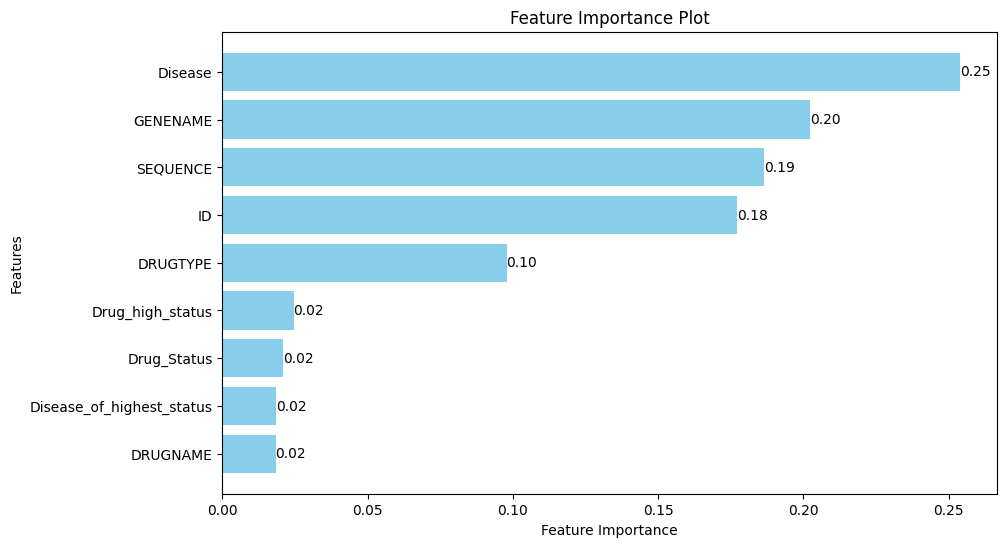

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances
feature_importances = model.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to have most important at the top

# Annotate each bar with the importance value
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.show()

# Based on feature importances

In [49]:
# When == X # 0.9651496076590609
# highly_corr_features = ['Disease', 'GENENAME', 'SEQUENCE', 'ID', 'DRUGTYPE', 'Drug_high_status'] #5th 0.9672110568929874
highly_corr_features = ['Disease', 'GENENAME', 'SEQUENCE', 'ID', 'DRUGTYPE'] #5th 0.9676325415789722
# highly_corr_features = ['Disease', 'GENENAME', 'SEQUENCE', 'ID'] #5th 0.9675450548138979
# highly_corr_features = ['Disease', 'GENENAME', 'SEQUENCE'] #5th 0.9563599195530632

X_highly_dropped = X[highly_corr_features]
y_highly_dropped = y

X_train, X_test, y_train, y_test = train_test_split(X_highly_dropped, y_highly_dropped,
                                                    stratify=y_highly_dropped, shuffle=True,
                                                    random_state=42)

params = {'max_depth': 18, 'learning_rate': 0.02554741000702669, 'n_estimators': 418, 
          'subsample': 0.9899632082718985, 'colsample_bytree': 0.8226626583591214, 
          'gamma': 0.9701683008405076, 'min_child_weight': 3}

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.9676325415789722

In [50]:
import xgboost as xgb

params = {'max_depth': 18, 'learning_rate': 0.02554741000702669, 'n_estimators': 418, 
          'subsample': 0.9899632082718985, 'colsample_bytree': 0.8226626583591214, 
          'gamma': 0.9701683008405076, 'min_child_weight': 3}

model = xgb.XGBClassifier(**params)

model.fit(X, y)

preds = model.predict(test)

In [51]:
sub['Prediction'] = preds
sub['Prediction'] = sub['Prediction'].map(category_to_label)
sub.to_csv('XGB_5thiter.csv', index=False)
sub.head()    # 0.96742

,ID,Prediction
0,1076,Approved
1,190816,Phase 3
2,180551,Phase 1
3,51630,Approved
4,50566,Phase 1/2


----

# On Full Dataset - without dropping columns

In [46]:
import pandas as pd
data = pd.read_csv('/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/train.csv')
data.head()

,ID,TargetID,DRUGID,DRUGTYPE,Drug_high_status,DRUGNAME,PUBCHCID,Disease_of_highest_status,Drug_Status,UNIPROID,TARGNAME,GENENAME,SYNONYMS,FUNCTION,BIOCLASS,SEQUENCE,Disease,Accession Number,Target_Status
0,140736,T51115,D0L4YD,Small molecular drug,Approved,Solifenacin,154059,Overactive bladder,Approved,CAC1C_HUMAN,Voltage-gated calcium channel alpha Cav1.2 (CA...,CACNA1C,Voltage-gated calcium channel subunit alpha Ca...,Mediates influx of calcium ions into the cytop...,Voltage-gated ion channel,MVNENTRMYIPEENHQGSNYGSPRPAHANMNANAAAGLAPEHIPTP...,Genetic cardiac arrhythmia,Q13936,Terminated
1,133048,T60529,D03NMM,Small molecular drug,Investigative,AM-643,46843035,Dermatological disease,Investigative,PGH1_HUMAN,Prostaglandin G/H synthase 1 (COX-1),PTGS1,Prostaglandin-endoperoxide synthase 1; Prostag...,Converts arachidonate to prostaglandin H2 (PGH...,Paired donor oxygen oxidoreductase,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,Rheumatoid arthritis,P23219,Approved
2,60493,T80975,D0T2ER,Small molecular drug,Phase 1,TAK-593,24767976,Solid tumour/cancer,Phase 1,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,KDR,VEGFR2; VEGFR-2; VEGF-2 receptor; Protein-tyro...,Plays an essential role in the regulation of a...,Kinase,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,Renal cell carcinoma,P35968,Approved
3,169176,T92072,D07ESH,Small molecular drug,Discontinued in Phase 3,PF-1913539,176408,Alzheimer disease,Discontinued in Phase 3,AA1R_HUMAN,Adenosine A1 receptor (ADORA1),ADORA1,Adenosine receptor A1; A(1) adenosine receptor,The activity of this receptor is mediated by G...,GPCR rhodopsin,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,Hyper-lipoproteinaemia,P30542,Phase 2
4,120183,T30082,D0Q0RC,Small molecular drug,Approved,Ethopropazine,3290,Parkinson disease,Approved,ACES_HUMAN,Acetylcholinesterase (AChE),ACHE,YT; N-ACHE; ARACHE,Role in neuronal apoptosis. Terminates signal ...,Carboxylic ester hydrolase,MRPPQCLLHTPSLASPLLLLLLWLLGGGVGAEGREDAELLVTVRGG...,Oesophageal/gastroduodenal disorder,P22303,Approved


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.drop('Target_Status', axis=1),
                                                  data['Target_Status'], random_state=42,
                                                  stratify=data['Target_Status'], shuffle=True)
print("Done")

In [ ]:
data.columns

In [ ]:
le_cols = ['TargetID', 'DRUGID', 'DRUGTYPE', 'Drug_high_status', 'DRUGNAME',
       'PUBCHCID', 'Disease_of_highest_status', 'Drug_Status', 'UNIPROID',
       'TARGNAME', 'GENENAME', 'SYNONYMS', 'FUNCTION', 'BIOCLASS', 'SEQUENCE',
       'Disease', 'Accession Number']

from sklearn.preprocessing import LabelEncoder
for i in le_cols:
    le = LabelEncoder()
    X_train[i] = le.fit_transform(X_train[i])
    X_val[i] = X_val[i].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1 if pd.notna(x) else -1)
# X_test[col] = X_test[col].apply(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1 if pd.notna(x) else -1)
print("Done")

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# y_val = le.transform(y_val)
y_val = y_val.apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1 if pd.notna(x) else -1)
print(le.classes_)
print("Done")

In [ ]:
from xgboost import XGBClassifier
param = {'max_depth': 10, 'learning_rate': 0.09887667319531757, 'n_estimators': 286,
         'subsample': 0.8818473315577697, 'colsample_bytree': 0.7911835582470869, 
         'gamma': 0.5882283567417588, 'min_child_weight': 1} # nothing dropped (3rd submission)
model = XGBClassifier(**param)
model.fit(X_train, y_train, verbose=2)

preds = model.predict(X_val)

from sklearn.metrics import f1_score, accuracy_score

In [ ]:
accuracy_score(y_val, preds)


In [ ]:
f1_score(y_val, preds, average='weighted')

In [ ]:
print('Done')

In [ ]:
test = pd.read_csv('/kaggle/input/nexus-by-djs-nsdc-ultraceuticals/test.csv')
test.head()

In [ ]:
le_cols = ['TargetID', 'DRUGID', 'DRUGTYPE', 'Drug_high_status', 'DRUGNAME',
       'PUBCHCID', 'Disease_of_highest_status', 'Drug_Status', 'UNIPROID',
       'TARGNAME', 'GENENAME', 'SYNONYMS', 'FUNCTION', 'BIOCLASS', 'SEQUENCE',
       'Disease', 'Accession Number']

from sklearn.preprocessing import LabelEncoder
for i in le_cols:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])
    test[i] = test[i].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1 if pd.notna(x) else -1)
# X_test[col] = X_test[col].apply(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1 if pd.notna(x) else -1)
print("Done")

In [ ]:
preds = model.predict(test)

In [ ]:
# Define the list of categories in the order you want to encode them
categories = [
    'Application submitted', 'Approved', 'Approved (orphan drug)', 'BLA submitted', 'Clinical trial',
    'Discontinued in Phase 1', 'Discontinued in Phase 1/2', 'Discontinued in Phase 2', 'Discontinued in Phase 2/3',
    'Discontinued in Phase 2b', 'Discontinued in Phase 3', 'Discontinued in Phase 4',
    'Discontinued in Preregistration', 'IND submitted', 'Investigative', 'Patented', 'Phase 0', 'Phase 1', 'Phase 1/2',
    'Phase 1/2a', 'Phase 1b', 'Phase 1b/2a', 'Phase 2', 'Phase 2/3', 'Phase 2a', 'Phase 2b', 'Phase 3', 'Phase 4',
    'Preclinical', 'Preregistration', 'Registered', 'Terminated', 'Withdrawn from market'
]

# Create a dictionary mapping each category to its corresponding label (0, 1, 2, etc.)
category_to_label = {idx : category for idx, category in enumerate(categories)}

# Function to apply the mapping
# def map_to_label(value):
#     return category_to_label.get(value, 1)  # Returns 1 if the value is not found in the dictionary
category_to_label

In [ ]:
sub = pd.DataFrame(test['ID'])
sub['Prediction'] = preds
sub.head()

In [ ]:
sub['Prediction'] = sub['Prediction'].map(category_to_label)
sub.head()

In [ ]:
sub.to_csv('XGB_on_full_data.csv', index=False)
sub.head()

In [ ]:
print('Done!')